# Image Recognition with Transfer Learning (CIFAR-10 Dataset)

## Practical Test: Neural Networks & Deep Learning

This notebook implements transfer learning for image classification on the CIFAR-10 dataset using pre-trained model (MobileNetV2) and compares performance with a custom CNN.

### Dataset
- **CIFAR-10**: 60,000 32x32 color images in 10 classes
- Source: https://www.cs.toronto.edu/~kriz/cifar.html


In [ ]:
# Import necessary libraries

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import itertools
import time

print("TensorFlow version:", tf.__version__)
print("Library imports successful.!")


TensorFlow version: 2.20.0


NameError: name 'keras' is not defined

## Task 1: Load CIFAR-10 Dataset and Normalize Image Data


In [ ]:
# Load CIFAR-10 dataset using TensorFlow's built-in loader
# Automatically downloads the dataset from the official source:
# https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
# The dataset is cached in ~/.keras/datasets/ (or C:\Users\<username>\.keras\datasets\ on Windows)
# Subsequent runs will use the cached version without re-downloading
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# CIFAR-10 class names (standard order as defined in the official dataset)
# Source: https://www.cs.toronto.edu/~kriz/cifar.html
# The labels 0-9 correspond to these classes in order
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Flatten labels from (N, 1) to (N,)
train_labels = train_labels.flatten()
test_labels = test_labels.flatten()

print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Class names: {class_names}")
print(f"Image data type: {train_images.dtype}")
print(f"Image value range: [{train_images.min()}, {train_images.max()}]")


Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000,)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000,)
Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Image data type: uint8
Image value range: [0, 255]


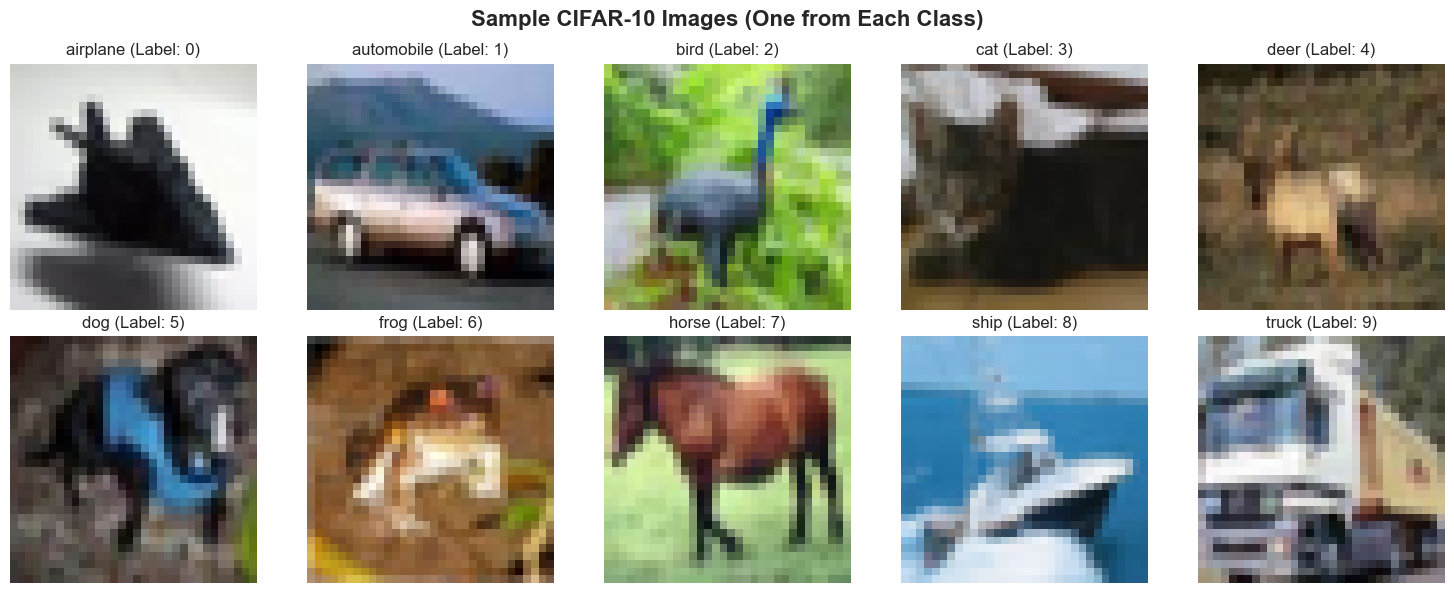

In [ ]:
# Visualize sample images from each class
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample CIFAR-10 Images (One from Each Class)', fontsize=16, fontweight='bold')

for i in range(10):
    row = i // 5
    col = i % 5
    # Find first image of each class
    class_idx = np.where(train_labels == i)[0][0]
    axes[row, col].imshow(train_images[class_idx])
    axes[row, col].set_title(f'{class_names[i]} (Label: {i})', fontsize=12)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Normalize pixel values to [0, 1] and convert labels to categorical
# Function to normalize images in batches to avoid memory issues
def normalize_images(images, batch_size=2000):
   
    # Normalize images from [0, 255] to [0, 1] in batches to avoid memory errors.
    # Uses smaller batches and processes incrementally.
    
    # Args:
    #  -  images: numpy array of shape (num_samples, height, width, channels) with dtype uint8
    #  -  batch_size: number of images to process at once (default: 2000)
    
    # Returns:
    #  -  normalized_images: numpy array with dtype float32, values in [0, 1]
 
    num_samples = images.shape[0]
    image_shape = images.shape[1:]
    
    # Process in batches and accumulate
    normalized_batches = []
    
    print(f"Normalizing {num_samples} images in batches of {batch_size}...")
    print("-"*60)
    for i in range(0, num_samples, batch_size):
        end_idx = min(i + batch_size, num_samples)
        # Normalize batch (creates new array, but smaller)
        batch_normalized = images[i:end_idx].astype('float32') / 255.0
        normalized_batches.append(batch_normalized)
        
        # Clear reference to original batch
        del batch_normalized
        
        if (i // batch_size + 1) % 5 == 0 or end_idx == num_samples:
            print(f"  Processed {end_idx}/{num_samples} images ({100*end_idx/num_samples:.1f}%)")
        
        # Garbage collect every 10 batches
        if (i // batch_size + 1) % 10 == 0:
            gc.collect()
    
    # Concatenate all batches
    print("  Concatenating normalized batches...")
    normalized = np.concatenate(normalized_batches, axis=0)
    del normalized_batches
    gc.collect()
    
    return normalized

# Normalize images in batches (using smaller batch size for low-memory systems)
print("Normalizing pixel values from [0, 255] to [0, 1]...")
train_images = normalize_images(train_images, batch_size=2000)
print("Training images normalized")
print("\n")

test_images = normalize_images(test_images, batch_size=2000)
print("Test images normalized")
# Convert labels to categorical (one-hot encoding)
train_labels_categorical = to_categorical(train_labels, 10)
test_labels_categorical = to_categorical(test_labels, 10)

print(f"\nNormalized training images range: [{train_images.min():.3f}, {train_images.max():.3f}]")
print(f"Training labels (categorical) shape: {train_labels_categorical.shape}")
print(f"Test labels (categorical) shape: {test_labels_categorical.shape}")

# Split training data into train and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(
    train_images, train_labels_categorical, 
    test_size=0.2, random_state=42, stratify=train_labels
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {test_images.shape[0]} samples")


Normalizing pixel values from [0, 255] to [0, 1]...
Normalizing 50000 images in batches of 2000...
------------------------------------------------------------
  Processed 10000/50000 images (20.0%)
  Processed 20000/50000 images (40.0%)
  Processed 30000/50000 images (60.0%)
  Processed 40000/50000 images (80.0%)
  Processed 50000/50000 images (100.0%)
  Concatenating normalized batches...
Training images normalized


Normalizing 10000 images in batches of 2000...
------------------------------------------------------------
  Processed 10000/10000 images (100.0%)
  Concatenating normalized batches...
Test images normalized

Normalized training images range: [0.000, 1.000]
Training labels (categorical) shape: (50000, 10)
Test labels (categorical) shape: (10000, 10)

Training set: 40000 samples
Validation set: 10000 samples
Test set: 10000 samples


## Task 2: Use Pre-trained Models for Transfer Learning

We implement transfer learning using VGG16, ResNet50, and MobileNetV2. Since these models expect 224x224 images, we need to upsample CIFAR-10 images from 32x32 to 224x224.


In [ ]:
## VGG16 Transfer Learning Model

# Generator class that upsamples images on-the-fly during training
# This avoids storing all upsampled images in memory at once. Only one batch of upsampled images is in memory at any time.
class UpsampledDataGenerator(Sequence):
    
    def __init__(self, images, labels, batch_size=32, target_size=(224, 224)):
        self.images = images  # Original 32x32 images (already normalized)
        self.labels = labels   # Labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.num_samples = len(images)
    
    def __len__(self):
        return int(np.ceil(self.num_samples / self.batch_size))
    
    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, self.num_samples)
        
        # Get batch of original 32x32 images
        batch_images = self.images[start_idx:end_idx]
        batch_labels = self.labels[start_idx:end_idx]
        
        # Upsample batch on-the-fly (only this batch is in memory)
        upsampled_batch = tf.image.resize(batch_images, self.target_size, method='bilinear')
        
        return upsampled_batch.numpy(), batch_labels

print("Creating data generators for VGG16 (upsamples on-the-fly during training)...")
print("This approach avoids storing all upsampled images in memory.")

# Create generators for training and validation (upsample on-the-fly)
train_generator_vgg16 = UpsampledDataGenerator(X_train, y_train, batch_size=32, target_size=(224, 224))
val_generator_vgg16 = UpsampledDataGenerator(X_val, y_val, batch_size=32, target_size=(224, 224))

print(f"-> Training generator: {len(train_generator_vgg16)} batches of ~32 images")
print(f"-> Validation generator: {len(val_generator_vgg16)} batches of ~32 images")
print("\nNote: Images are upsampled from 32x32 to 224x224 on-the-fly during training.")

# For test set, also use generator (or we can upsample test set in very small batches if needed)
print("\nCreating test generator...")
test_generator_vgg16 = UpsampledDataGenerator(test_images, test_labels_categorical, batch_size=32, target_size=(224, 224))
print(f"-> Test generator: {len(test_generator_vgg16)} batches of ~32 images")

# Create VGG16 base model with ImageNet pre-trained weights
# include_top=False means we exclude the final classification layer
base_model_vgg16 = VGG16(
    weights='imagenet',           # Use pre-trained ImageNet weights
    include_top=False,            # Exclude the top classification layer
    input_shape=(224, 224, 3)     # Input shape for VGG16
)

# Freeze all layers in the base model (they won't be trained)
base_model_vgg16.trainable = False

# Calculate parameter counts for base model
base_trainable_params = sum([tf.keras.backend.count_params(w) for w in base_model_vgg16.trainable_weights])
base_total_layers = len(base_model_vgg16.layers)

print("\nVGG16 Base Model:")
print(f"Total layers: {base_total_layers}")
print(f"Trainable parameters: {base_trainable_params:,}")

# Build the complete transfer learning model
model_vgg16 = models.Sequential([
    base_model_vgg16,                                   # Pre-trained VGG16 base
    layers.GlobalAveragePooling2D(),                    # Global average pooling
    layers.Dense(512, activation='relu'),               # Dense layer
    layers.Dropout(0.5),                                # Dropout for regularization
    layers.Dense(256, activation='relu'),               # Another dense layer
    layers.Dropout(0.3),                                # Dropout
    layers.Dense(10, activation='softmax')              # Output layer for 10 classes
])

# Compile the model
model_vgg16.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Calculate parameter counts for the complete model
total_params = model_vgg16.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model_vgg16.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model_vgg16.non_trainable_weights])

print("\n" + "-"*70)
print("VGG16 Transfer Learning Model Summary:")
print("-"*70)
model_vgg16.summary()
print("\nTotal parameters:", f"{total_params:,}")
print("Trainable parameters:", f"{trainable_params:,}")
print("Non-trainable parameters:", f"{non_trainable_params:,}")


Creating data generators for VGG16 (upsamples on-the-fly during training)...
This approach avoids storing all upsampled images in memory.
-> Training generator: 1250 batches of ~32 images
-> Validation generator: 313 batches of ~32 images

Note: Images will be upsampled from 32x32 to 224x224 on-the-fly during training.
This saves memory but may slightly slow down training.

Creating test generator...
-> Test generator: 313 batches of ~32 images

VGG16 Base Model:
Total layers: 19
Trainable parameters: 0

----------------------------------------------------------------------
VGG16 Transfer Learning Model Summary:
----------------------------------------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,111,242 (57.64 MB)

 Trainable params: 396,554 (1.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


Total parameters: 15,111,242
Trainable parameters: 396,554
Non-trainable parameters: 14,714,688


In [ ]:
## ResNet50 Transfer Learning Model

print("Creating data generators for ResNet50 (upsamples on-the-fly during training)...")
print("This approach avoids storing all upsampled images in memory.")

# Create generators for training and validation (upsample on-the-fly)
# Note: ResNet50 also expects 224x224 input images
train_generator_resnet50 = UpsampledDataGenerator(X_train, y_train, batch_size=32, target_size=(224, 224))
val_generator_resnet50 = UpsampledDataGenerator(X_val, y_val, batch_size=32, target_size=(224, 224))

print(f"-> Training generator: {len(train_generator_resnet50)} batches of ~32 images")
print(f"-> Validation generator: {len(val_generator_resnet50)} batches of ~32 images")
print("\nNote: Images are upsampled from 32x32 to 224x224 on-the-fly during training.")

# For test set, also use generator
print("\nCreating test generator...")
test_generator_resnet50 = UpsampledDataGenerator(test_images, test_labels_categorical, batch_size=32, target_size=(224, 224))
print(f"-> Test generator: {len(test_generator_resnet50)} batches of ~32 images")

# Create ResNet50 base model with ImageNet pre-trained weights
# include_top=False means we exclude the final classification layer
base_model_resnet50 = ResNet50(
    weights='imagenet',           # Use pre-trained ImageNet weights
    include_top=False,            # Exclude the top classification layer
    input_shape=(224, 224, 3)     # Input shape for ResNet50
)

# Freeze all layers in the base model (they won't be trained)
base_model_resnet50.trainable = False

# Calculate parameter counts for base model
base_trainable_params = sum([tf.keras.backend.count_params(w) for w in base_model_resnet50.trainable_weights])
base_total_layers = len(base_model_resnet50.layers)

print("\nResNet50 Base Model:")
print(f"Total layers: {base_total_layers}")
print(f"Trainable parameters: {base_trainable_params:,}")

# Build the complete transfer learning model
model_resnet50 = models.Sequential([
    base_model_resnet50,                                  # Pre-trained ResNet50 base
    layers.GlobalAveragePooling2D(),                     # Global average pooling
    layers.Dense(512, activation='relu'),                # Dense layer
    layers.Dropout(0.5),                                 # Dropout for regularization
    layers.Dense(256, activation='relu'),                # Another dense layer
    layers.Dropout(0.3),                                 # Dropout
    layers.Dense(10, activation='softmax')               # Output layer for 10 classes
])

# Compile the model
model_resnet50.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Calculate parameter counts for the complete model
total_params = model_resnet50.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model_resnet50.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model_resnet50.non_trainable_weights])

print("\n" + "-"*70)
print("ResNet50 Transfer Learning Model Summary:")
print("-"*70)
model_resnet50.summary()
print("\nTotal parameters:", f"{total_params:,}")
print("Trainable parameters:", f"{trainable_params:,}")
print("Non-trainable parameters:", f"{non_trainable_params:,}")


Creating data generators for ResNet50 (upsamples on-the-fly during training)...
This approach avoids storing all upsampled images in memory.
-> Training generator: 1250 batches of ~32 images
-> Validation generator: 313 batches of ~32 images

Note: Images will be upsampled from 32x32 to 224x224 on-the-fly during training.
This saves memory but may slightly slow down training.

Creating test generator...
-> Test generator: 313 batches of ~32 images

ResNet50 Base Model:
Total layers: 175
Trainable parameters: 0

----------------------------------------------------------------------
ResNet50 Transfer Learning Model Summary:
----------------------------------------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,770,698 (94.49 MB)

 Trainable params: 1,182,986 (4.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


Total parameters: 24,770,698
Trainable parameters: 1,182,986
Non-trainable parameters: 23,587,712


In [ ]:
## MobileNetV2 Transfer Learning Model

print("Creating data generators for MobileNetV2 (upsamples on-the-fly during training)...")
print("This approach avoids storing all upsampled images in memory.")

# Create generators for training and validation (upsample on-the-fly)
# Note: MobileNetV2 also expects 224x224 input images
train_generator_mobilenet = UpsampledDataGenerator(X_train, y_train, batch_size=32, target_size=(224, 224))
val_generator_mobilenet = UpsampledDataGenerator(X_val, y_val, batch_size=32, target_size=(224, 224))

print(f"-> Training generator: {len(train_generator_mobilenet)} batches of ~32 images")
print(f"-> Validation generator: {len(val_generator_mobilenet)} batches of ~32 images")
print("\nNote: Images are upsampled from 32x32 to 224x224 on-the-fly during training.")

# For test set, also use generator
print("\nCreating test generator...")
test_generator_mobilenet = UpsampledDataGenerator(test_images, test_labels_categorical, batch_size=32, target_size=(224, 224))
print(f"-> Test generator: {len(test_generator_mobilenet)} batches of ~32 images")

# Create MobileNetV2 base model with ImageNet pre-trained weights
# include_top=False means we exclude the final classification layer
base_model_mobilenet = MobileNetV2(
    weights='imagenet',           # Use pre-trained ImageNet weights
    include_top=False,            # Exclude the top classification layer
    input_shape=(224, 224, 3)     # Input shape for MobileNetV2
)

# Freeze all layers in the base model (they won't be trained)
base_model_mobilenet.trainable = False

# Calculate parameter counts for base model
base_trainable_params = sum([tf.keras.backend.count_params(w) for w in base_model_mobilenet.trainable_weights])
base_total_layers = len(base_model_mobilenet.layers)

print("\nMobileNetV2 Base Model:")
print(f"Total layers: {base_total_layers}")
print(f"Trainable parameters: {base_trainable_params:,}")

# Build the complete transfer learning model
model_mobilenet = models.Sequential([
    base_model_mobilenet,                                 # Pre-trained MobileNetV2 base
    layers.GlobalAveragePooling2D(),                     # Global average pooling
    layers.Dense(512, activation='relu'),               # Dense layer
    layers.Dropout(0.5),                                 # Dropout for regularization
    layers.Dense(256, activation='relu'),               # Another dense layer
    layers.Dropout(0.3),                                 # Dropout
    layers.Dense(10, activation='softmax')               # Output layer for 10 classes
])

# Compile the model
model_mobilenet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Calculate parameter counts for the complete model
total_params = model_mobilenet.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model_mobilenet.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model_mobilenet.non_trainable_weights])

print("\n" + "-"*70)
print("MobileNetV2 Transfer Learning Model Summary:")
print("-"*70)
model_mobilenet.summary()
print("\nTotal parameters:", f"{total_params:,}")
print("Trainable parameters:", f"{trainable_params:,}")
print("Non-trainable parameters:", f"{non_trainable_params:,}")


## Task 3: Freeze Lower Layers, Retrain Top Layers for 10 Epochs

We train all three models (VGG16, ResNet50, MobileNetV2) for 10 epochs with frozen base layers. The custom classification heads will be trained while preserving the pre-trained ImageNet features.


In [ ]:
## Train VGG16 Model (10 Epochs)

print("="*70)
print("Training VGG16 Transfer Learning Model")
print("="*70)
print(f"Training samples: {len(train_generator_vgg16) * 32}")
print(f"Validation samples: {len(val_generator_vgg16) * 32}")
print(f"Epochs: 10")
print(f"Batch size: 32")
print(f"Optimizer: Adam (learning_rate=0.001)")
print("\nStarting training...")

# Train the model
history_vgg16 = model_vgg16.fit(
    train_generator_vgg16,
    epochs=10,
    validation_data=val_generator_vgg16,
    verbose=1,
    steps_per_epoch=len(train_generator_vgg16),
    validation_steps=len(val_generator_vgg16)
)

print("\n" + "="*70)
print("VGG16 Training Complete!")
print("="*70)
print(f"Final training accuracy: {history_vgg16.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history_vgg16.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history_vgg16.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history_vgg16.history['val_loss'][-1]:.4f}")

# Clear memory
gc.collect()


In [ ]:
## Train ResNet50 Model (10 Epochs)

print("="*70)
print("Training ResNet50 Transfer Learning Model")
print("="*70)
print(f"Training samples: {len(train_generator_resnet50) * 32}")
print(f"Validation samples: {len(val_generator_resnet50) * 32}")
print(f"Epochs: 10")
print(f"Batch size: 32")
print(f"Optimizer: Adam (learning_rate=0.001)")
print("\nStarting training...")

# Train the model
history_resnet50 = model_resnet50.fit(
    train_generator_resnet50,
    epochs=10,
    validation_data=val_generator_resnet50,
    verbose=1,
    steps_per_epoch=len(train_generator_resnet50),
    validation_steps=len(val_generator_resnet50)
)

print("\n" + "="*70)
print("ResNet50 Training Complete!")
print("="*70)
print(f"Final training accuracy: {history_resnet50.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history_resnet50.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history_resnet50.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history_resnet50.history['val_loss'][-1]:.4f}")

# Clear memory
gc.collect()


In [ ]:
## Train MobileNetV2 Model (10 Epochs)

print("_"*70)
print("Training MobileNetV2 Transfer Learning Model")
print("_"*70)
print(f"Training samples: {len(train_generator_mobilenet) * 32}")
print(f"Validation samples: {len(val_generator_mobilenet) * 32}")
print(f"Epochs: 10")
print(f"Batch size: 32")
print(f"Optimizer: Adam (learning_rate=0.001)")
print("\nStarting training...")

# Train the model
history_mobilenet = model_mobilenet.fit(
    train_generator_mobilenet,
    epochs=10,
    validation_data=val_generator_mobilenet,
    verbose=1,
    steps_per_epoch=len(train_generator_mobilenet),
    validation_steps=len(val_generator_mobilenet)
)

print("\n" + "_"*70)
print("MobileNetV2 Training Complete!")
print("_"*70)
print(f"Final training accuracy: {history_mobilenet.history['accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history_mobilenet.history['val_accuracy'][-1]:.4f}")
print(f"Final training loss: {history_mobilenet.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history_mobilenet.history['val_loss'][-1]:.4f}")

# Clear memory
gc.collect()
